<a href="https://colab.research.google.com/github/chihyanghsu0805/machine_learning/blob/tutorials/tutorials/keras/graph_representation_learning/node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Install packages

In [1]:
pip install networkx

In [2]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip",
    "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

# Exploratory Data Analysis

In [4]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

print(f"Movies data shape: {movies.shape}")
print(f"Ratings data shape: {ratings.shape}")

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [5]:
# Rows are movies, columns are [Id, title, genres]
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# rows are ratings, columns are [User, Movie, rating, timestamp]
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f727028a290>]],
      dtype=object)

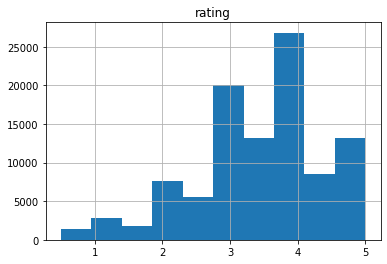

In [8]:
# Rating range from 0 to 5 with 0.5 as step size
ratings.hist("rating")

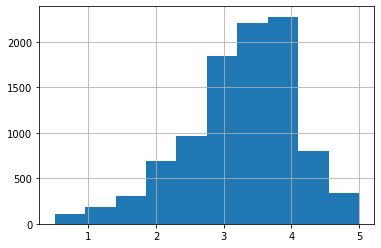

In [9]:
# Average ratings by movie
ratings.groupby("movieId")["rating"].mean().hist()

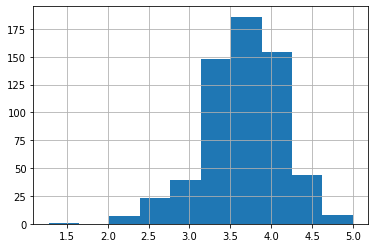

In [10]:
# Average ratings by user
ratings.groupby("userId")["rating"].mean().hist()

# Data Preprocessing

## Step 1: Build Graph

In [11]:
# Create the edges between movies rated by the same user with minimum rating
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

rated_movies = ratings[ratings.rating >= min_rating]
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in movies_grouped_by_users:
        
    current_movies = list(group[1]["movieId"]) # group[0] is index
        
    for i in range(len(current_movies)):

        item_frequency[current_movies[i]] += 1

        for j in range(i + 1, len(current_movies)):
            
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

In [12]:
# Build Graph with weighted edges that is greater than threshold
min_weight = 10 # How many users have the same rating
D = math.log(sum(item_frequency.values()))

movies_graph = nx.Graph()

for pair in pair_frequency:

    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

In [13]:
print(f"Total number of graph nodes: {movies_graph.number_of_nodes()}")
print(f"Total number of graph edges: {movies_graph.number_of_edges()}")

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [14]:
degrees = [movies_graph.degree[n] for n in movies_graph.nodes]
print(f"Average node degree: {round(sum(degrees) / len(degrees), 2)}")

Average node degree: 57.0


In [15]:
# Build vocabulary
vocabulary = ["NA"] + list(movies_graph.nodes) # movieId starts with 1
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [16]:
print(vocabulary_lookup)

{'NA': 0, 'movie_47': 1, 'movie_50': 2, 'movie_151': 3, 'movie_163': 4, 'movie_216': 5, 'movie_231': 6, 'movie_260': 7, 'movie_333': 8, 'movie_457': 9, 'movie_527': 10, 'movie_596': 11, 'movie_608': 12, 'movie_1029': 13, 'movie_1073': 14, 'movie_1080': 15, 'movie_1089': 16, 'movie_1136': 17, 'movie_1196': 18, 'movie_1197': 19, 'movie_1198': 20, 'movie_1206': 21, 'movie_1210': 22, 'movie_1213': 23, 'movie_1220': 24, 'movie_1222': 25, 'movie_1240': 26, 'movie_1270': 27, 'movie_1275': 28, 'movie_1278': 29, 'movie_1291': 30, 'movie_1517': 31, 'movie_1573': 32, 'movie_1617': 33, 'movie_1625': 34, 'movie_1732': 35, 'movie_2005': 36, 'movie_2094': 37, 'movie_2115': 38, 'movie_2116': 39, 'movie_2329': 40, 'movie_2387': 41, 'movie_2459': 42, 'movie_2470': 43, 'movie_2502': 44, 'movie_2529': 45, 'movie_2542': 46, 'movie_2571': 47, 'movie_2700': 48, 'movie_2716': 49, 'movie_2858': 50, 'movie_2949': 51, 'movie_2959': 52, 'movie_2987': 53, 'movie_3033': 54, 'movie_3052': 55, 'movie_3147': 56, 'movi

## Step 2: Use biased random walk to generate training data

### Implement the biased random walk

A random walk starts from a given node, and randomly picks a neighbour node to move to.
If the edges are weighted, the neighbour is selected *probabilistically* with
respect to weights of the edges between the current node and its neighbours.
This procedure is repeated for `num_steps` to generate a sequence of *related* nodes.

The [*biased* random walk](https://en.wikipedia.org/wiki/Biased_random_walk_on_a_graph) balances between **breadth-first sampling**
(where only local neighbours are visited) and **depth-first sampling**
(where  distant neighbours are visited) by introducing the following two parameters:

1. **Return parameter** (`p`): Controls the likelihood of immediately revisiting
a node in the walk. Setting it to a high value encourages moderate exploration,
while setting it to a low value would keep the walk local.
2. **In-out parameter** (`q`): Allows the search to differentiate
between *inward* and *outward* nodes. Setting it to a high value biases the
random walk towards local nodes, while setting it to a low value biases the walk
to visit nodes which are further away.

In [17]:
def next_step(graph, previous, current, p, q):

    neighbors = list(graph.neighbors(current))
    weights = []

    for neighbor in neighbors:
        
        if neighbor == previous:            
            weights.append(graph[current][neighbor]["weight"] / p)

        elif graph.has_edge(neighbor, previous):            
            weights.append(graph[current][neighbor]["weight"])

        else:
            weights.append(graph[current][neighbor]["weight"] / q)
    
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next

In [18]:
def random_walk(graph, num_walks, num_steps, p, q):
    
    walks = []
    nodes = list(graph.nodes())
    
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in nodes:
            
            walk = [node]
            
            while len(walk) < num_steps:

                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(graph, previous, current, p, q)
                walk.append(next)

            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)

    return walks

In [19]:
p = 1
q = 1
num_walks = 5
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print(f"Number of walks generated: {len(walks)}")

Number of walks generated: 7025


### Generate positive and negative examples

To train a skip-gram model, we use the generated walks to create positive and
negative training examples. Each example includes the following features:

1. `target`: A movie in a walk sequence.
2. `context`: Another movie in a walk sequence.
3. `weight`: How many times these two movies occured in walk sequences.
4. `label`: The label is 1 if these two movies are samples from the walk sequences,
otherwise (i.e., if randomly sampled) the label is 0.

In [20]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    
    example_weights = defaultdict(int)

    for sequence in sequences:

        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )

        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)

In [21]:
num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

In [22]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (881035,)
Contexts shape: (881035,)
Labels shape: (881035,)
Weights shape: (881035,)


### Convert the data into `tf.data.Dataset` objects

In [23]:
def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [24]:
batch_size = 1024

dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

# Train the skip-gram model



Our skip-gram is a simple binary classification model that works as follows:

1. An embedding is looked up for the `target` movie.
2. An embedding is looked up for the `context` movie.
3. The dot product is computed between these two embeddings.
4. The result (after a sigmoid activation) is compared to the label.
5. A binary crossentropy loss is used.

In [25]:
learning_rate = 0.001
embedding_dim = 32
num_epochs = 10

### Build the model

In [26]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }

    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )

    target_embeddings = embed_item(inputs["target"])
    context_embeddings = embed_item(inputs["context"])
    
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Train the model

In [27]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

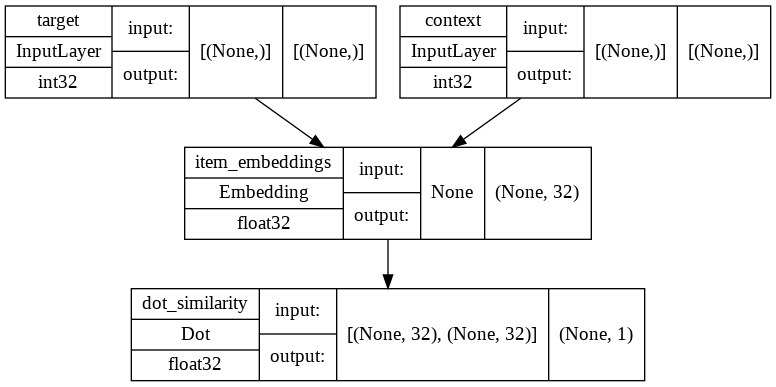

In [28]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

In [29]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
860/860 [==============================] - 5s 6ms/step - loss: 2.4616
Epoch 2/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3507
Epoch 3/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3369
Epoch 4/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3324
Epoch 5/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3288
Epoch 6/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3251
Epoch 7/10
860/860 [==============================] - 8s 10ms/step - loss: 2.3216
Epoch 8/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3189
Epoch 9/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3165
Epoch 10/10
860/860 [==============================] - 5s 6ms/step - loss: 2.3145


### Test the model by query movies

In [30]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

In [31]:
def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

In [32]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 32)


In [33]:
movie_in_graph = []
for node in list(movies_graph.nodes):
    movie_in_graph.append(get_movie_title_by_id(node))

num_queries = 10

query_movies = random.choices(movie_in_graph, k=num_queries)
print(query_movies)

['Louis C.K.: Live at the Beacon Theater (2011)', 'Platoon (1986)', 'Night on Earth (1991)', 'Bambi (1942)', 'Come and See (Idi i smotri) (1985)', 'Private Parts (1997)', 'Star Trek II: The Wrath of Khan (1982)', 'Fear and Loathing in Las Vegas (1998)', 'Good Will Hunting (1997)', 'Dark Knight, The (2008)']


In [34]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [35]:
# Compute cosine similarity between the embeddings of queries and other movies
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings, axis=1),
    tf.math.l2_normalize(movie_embeddings, axis=1),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [36]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}, {similarities[idx][token]:0.2f}")
    print()

Louis C.K.: Live at the Beacon Theater (2011)
---------------------------------------------
- Louis C.K.: Live at the Beacon Theater (2011), 1.00
- Captain America: The Winter Soldier (2014), 0.90
- X-Men: First Class (2011), 0.86
- Doctor Strange (2016), 0.83
- Wolf of Wall Street, The (2013), 0.82

Platoon (1986)
--------------
- Platoon (1986), 1.00
- Big Lebowski, The (1998), 0.93
- Apocalypse Now (1979), 0.93
- One Flew Over the Cuckoo's Nest (1975), 0.93
- Goodfellas (1990), 0.93

Night on Earth (1991)
---------------------
- Night on Earth (1991), 1.00
- My Left Foot (1989), 0.91
- Heavy Metal (1981), 0.91
- How to Train Your Dragon 2 (2014), 0.90
- Ghost World (2001), 0.90

Bambi (1942)
------------
- Bambi (1942), 1.00
- Girl with the Dragon Tattoo, The (Män som hatar kvinnor) (2009), 0.64
- Addams Family, The (1991), 0.63
- Star Wars: Episode VII - The Force Awakens (2015), 0.60
- Whiplash (2014), 0.57

Come and See (Idi i smotri) (1985)
----------------------------------
- C

### Visualize the Similarity

Embeddings shape: (1406, 32)


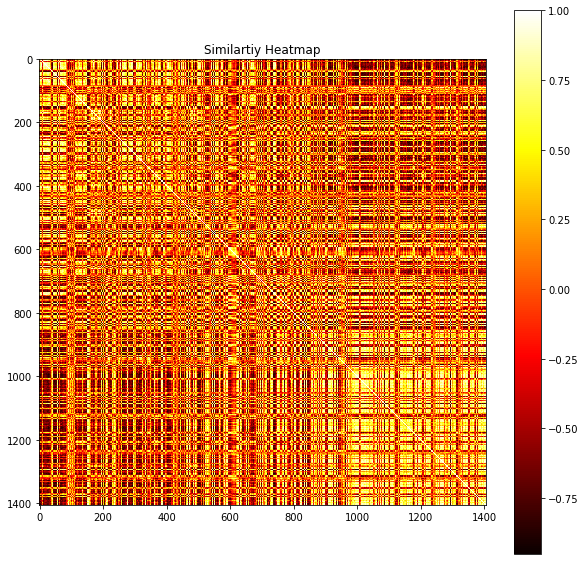

In [38]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print(f"Embeddings shape: {movie_embeddings.shape}")

all_similarities = tf.linalg.matmul(
    tf.math.l2_normalize(movie_embeddings, axis=1),
    tf.math.l2_normalize(movie_embeddings, axis=1),
    transpose_b=True,
)

plt.figure(figsize=(10,10))
plt.imshow(all_similarities.numpy(), cmap='hot', interpolation='nearest')
plt.title("Similartiy Heatmap")
plt.colorbar()